# Lecture 8 - Applications of Image Processing in Machine Learning

In this notebook, we will apply image processing in preparing our dataset for a machine learning algorthim.

Authored by:
Benjur Emmanuel L. Borja

---

## Leaf Classification
In the previous lectures, we discussed how to visualize, enhance, and extract information from images. We now apply the different algorithms that we have learned to create a leaf classification algorithm. Let's try it out. The file *leaves.zip* contains images of fives classes of leaves. We need to create a pipeline that would
1. Read and clean the images
1. Segment objects of interest
1. Extract features from the objects
1. Train an ML model

Take note that each of the steps can affect the accuracy of our model. Prioritizing which step to update will rely on heuristics. Let's practice:

#### Breakout Room Exercise:
Create a machine learning pipeline and try to reach the highest accuracy possible. Make sure that you are able to answer the corresponding questions.
1. Did you apply any data cleaning methods to prepare the images? If yes, what are these methods?<br><br>
Upon inspection of the images, it was observed that there are some artifacts from the scanning process. To address this, we first convert the image to grayscale, then simply binarize the result using a threshold of 0.39.


2. What algorithms did you use to segment the different leaves? What worked best?<br><br>
As mentioned above, there were observed artifacts from scanning, and as well as some leaf samples are touching, which results in conjoined continuous elements.  Therefore, morphological operations (i.e. erosion) was used to ensure that each leaf image segments neatly, as much as possible.  To address any samples that re still conjoined, we simply filter the dataset to only include up to the $95^{th}$ percentile in terms of segment area.


3. What are the features that you have extracted from the leaves? What are the derived features that you have extracted? And what are the significant features in classifying each leaf?<br><br>
The following features were extracted using skimage's regionprops function:
- perimeter - approximation of the image contour length
- area - number of pixels in the region
- bbox_area - number of pixels contained by the bounding box
- convex_area - number of pixels in the convex hull image,
- eccentricity - ratio of the focal distance of the circumscribed elipse to the major axis length
- equivalent_diameter - diameter of the circle with the same area as the region
- extent - ratio of area to bounding box area
- filled_area - number of pixels in the area, plus pixels of all the holes
- major_axis_length - major exis of the circumscribed elipse
- minor_axis_length - minor exis of the circumscribed elipse
- local_centroid_y - bounding box centroid - y
- local_centroid_x - bounding box centroid - x
- euler_number - number of connected components subtracted by number of holes
- perimeter_crofton - perimeter from the Crofton formula
- solidity - ratio of area to convex hull area

In terms of derived features, we experimented with including the ratio of perimeter to area, and the ratio of the minor axis length to the major axis length.

4. How does the limited number of samples affect your training?<br><br>
On the one hand, it is reasonable to say that the limited number of samples makes it easier for the machine to learn this particular dataset.  However, at the same time, it is hampered in its generalizability.  


5. What machine learning algorithm did you use? What is your best performing algorithm?<br><br>
The chosen model for the experiment is the Random Forest Classifier. This is primarily due to its speed.  While the best result is when we add the **ratio between the axis lengths ($90.6%$)**, it appears that neither of the additional features improved the model significantly.  The resultsing test accuracies are within one percent (2%) of each other. More research and experiments are needed.

In [75]:
import os
import numpy as np
from skimage import data, io, filters
from skimage.measure import label, regionprops
from skimage.morphology import erosion, closing
from skimage.color import label2rgb, rgb2gray
import matplotlib.pyplot as plt

In [76]:
kernel = np.array([[0,0,1,1,1],
                   [0,1,1,1,1],
                   [1,1,1,1,1]])

In [104]:
leaves = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[]}
for img in os.listdir(os.getcwd()):
    if img.startswith('plant'):
        leaves[img[5]].append(erosion(rgb2gray(io.imread(img)) < 0.39,
                                      kernel))

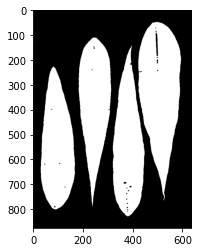

In [105]:
plt.imshow(leaves['A'][0], 'gray')

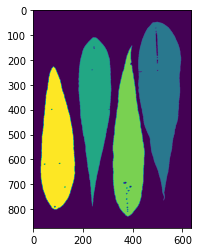

In [106]:
sample = leaves['A'][0]
sample_labeled = label(sample)
plt.imshow(sample_labeled)

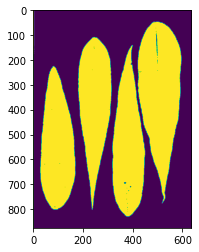

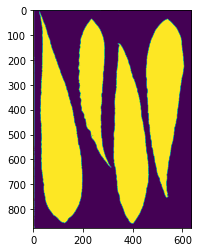

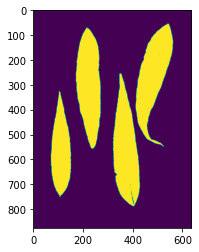

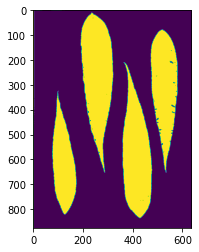

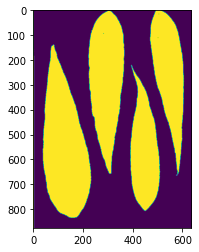

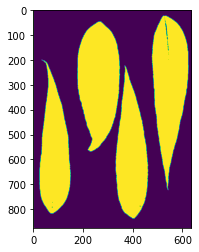

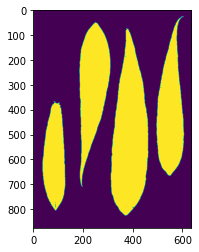

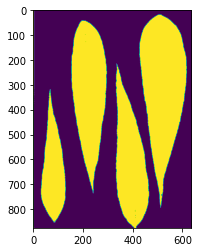

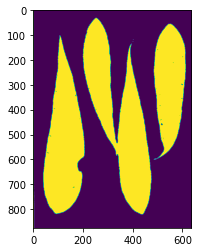

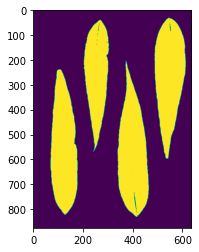

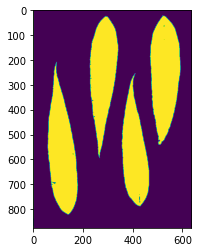

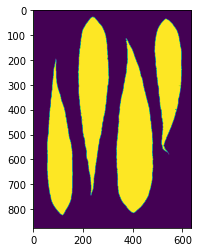

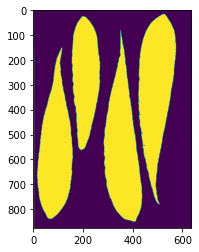

In [152]:
for img in os.listdir(os.getcwd()):
    if img.startswith('plantA'):
        plt.imshow(rgb2gray(io.imread(img)) < 0.39)
        plt.show()

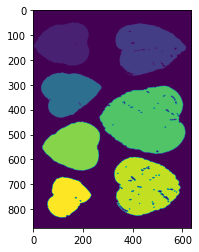

In [109]:
sample2 = leaves['B'][0]
sample2_labeled = label(sample2)
plt.imshow(sample2_labeled)

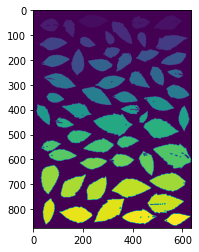

In [110]:
sample3 = leaves['C'][0]
sample3_labeled = label(sample3)
plt.imshow(sample3_labeled)

In [111]:
sample3_props=regionprops(sample3_labeled)
sample3_props=sorted(sample3_props, key=lambda x: x.area, reverse=True)[1:]
print(sample3_props[-5].area, sample3_props[-4].area)

3 2


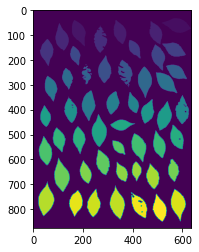

In [84]:
sample3 = leaves['D'][0]
sample3_labeled = label(sample3)
plt.imshow(sample3_labeled)

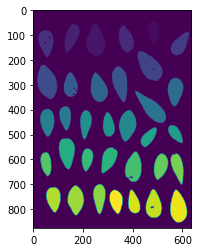

In [112]:
sample3 = leaves['E'][0]
sample3_labeled = label(sample3)
plt.imshow(sample3_labeled)

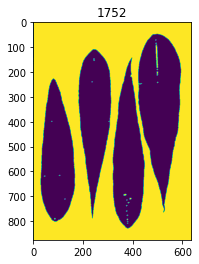

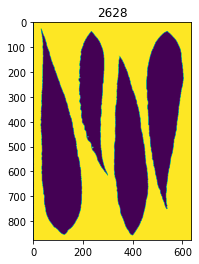

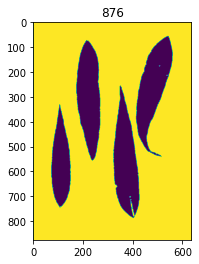

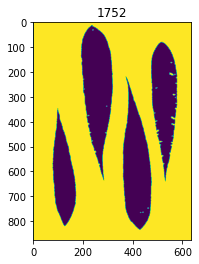

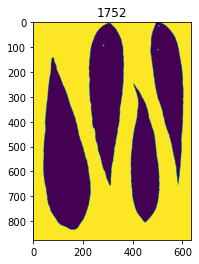

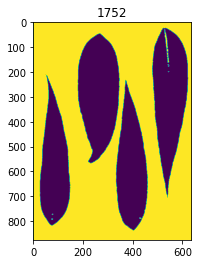

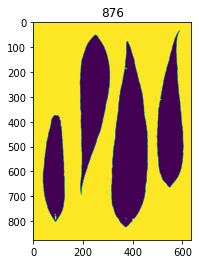

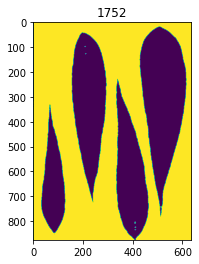

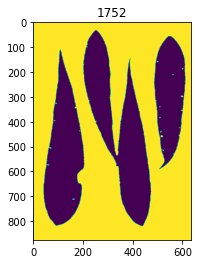

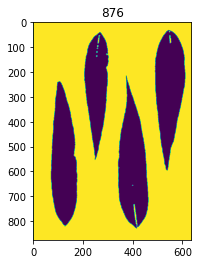

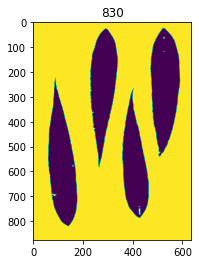

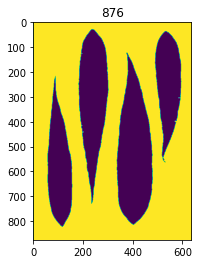

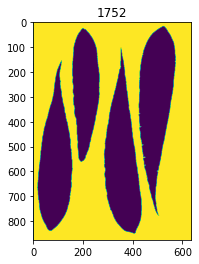

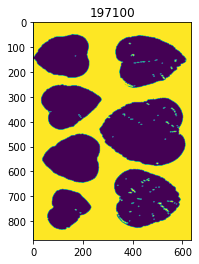

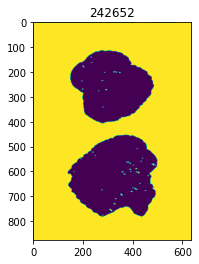

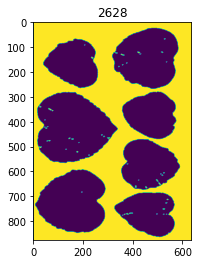

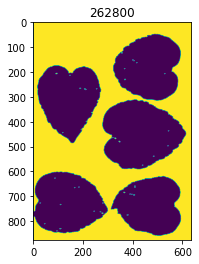

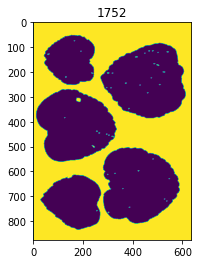

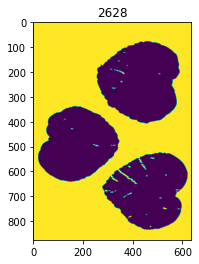

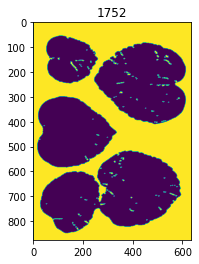

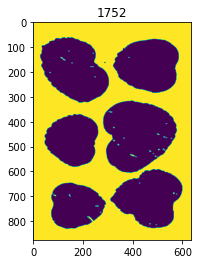

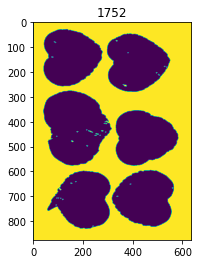

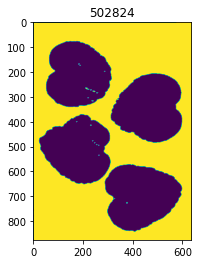

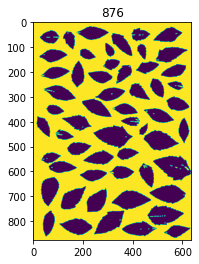

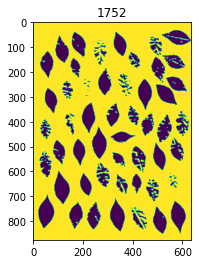

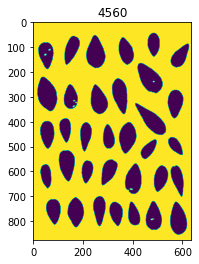

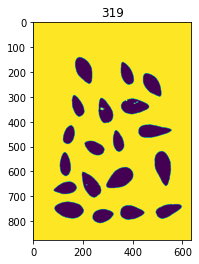

In [120]:
for leaf_class, images in leaves.items():
    for img in images:
        temp = label(img)
        temp_props = regionprops(temp)
        plt.imshow(temp==0)
        plt.title(f'{temp_props[0].bbox_area}')
        plt.show()

In [185]:
# major_axis_length, local_centroid, filled_area, extent, equivalent_diameter,
# eccentricity, convex_area, bbox_area, area, perimeter, minor_axis_length

import pandas as pd

data = pd.DataFrame()

for leaf_class, images in leaves.items():
    for img in images:
        temp = label(img)
        temp_props = regionprops(temp)
        temp_props = [x for x in temp_props if x.area > 100]
        temp_props = [[x.perimeter, x.area, x.bbox_area, x.convex_area,
                       x.eccentricity, x.equivalent_diameter, x.extent,
                       x.filled_area, x.major_axis_length,
                       x.minor_axis_length, x.local_centroid[0],
                       x.local_centroid[1], x.euler_number, x.solidity,
                       leaf_class]
                      for x in temp_props]
        data = pd.concat([data, pd.DataFrame(np.array(temp_props))])

In [186]:
data.columns = ['perimeter', 'area', 'bbox_area', 'convex_area',
                'eccentricity', 'equivalent_diameter', 'extent',
                'filled_area', 'major_axis_length', 'minor_axis_length',
                'local_centroid_y', 'local_centroid_x', 'euler', 'solidity',
                'class']

In [187]:
data = data[data.area.astype(float) < data.area.astype(float).quantile(0.95)]

X = data.iloc[:,:-1].astype(float)
Y = data['class']

X.describe()

,perimeter,area,bbox_area,convex_area,eccentricity,equivalent_diameter,extent,filled_area,major_axis_length,minor_axis_length,local_centroid_y,local_centroid_x,euler,solidity
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,663.834682,15967.310954,27985.696113,18772.547703,0.829478,113.265694,0.629944,16019.257951,265.246759,80.548936,126.042499,48.882566,-0.667845,0.900393
std,544.688045,20940.770619,47416.278346,28204.562513,0.177992,86.762285,0.147923,20992.497875,280.881065,74.449697,138.949066,38.568380,3.493041,0.142308
min,45.627417,103.000000,103.000000,103.000000,0.160207,11.451798,0.004938,103.000000,13.565450,0.000000,0.000000,0.000000,-31.000000,0.009825
25%,262.814755,2489.000000,4183.000000,2755.000000,0.825015,56.294659,0.574495,2528.500000,88.501715,41.046784,33.224947,24.134395,-1.000000,0.912838
50%,343.806133,3994.000000,6540.000000,4266.000000,0.865297,71.311421,0.629047,3997.000000,113.795177,51.738385,52.634532,37.659745,1.000000,0.952869
75%,1083.043289,31798.000000,49086.500000,35133.500000,0.972688,201.205981,0.712019,32007.000000,370.029779,103.064860,156.291373,62.515708,1.000000,0.971785
max,2873.572727,68600.000000,502824.000000,252726.000000,1.000000,295.540577,1.000000,68686.000000,1222.345030,471.031488,717.234813,162.353358,1.000000,1.000000


In [ ]:
import seaborn as sns

sns.pairplot(X)

## The Models

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

Population per class:    class
A     58
B     50
C     57
D     63
E     55

1.25 * Proportion Chance Criterion: 25.13922011761915%


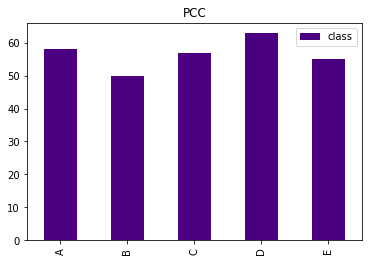

In [158]:
# PCC

from collections import Counter
state_counts = Counter(Y)
df_state = pd.DataFrame.from_dict(state_counts, orient='index',
                                  columns=['class'])
df_state.plot(kind='bar', color='indigo', title='PCC')

num=(df_state['class']/df_state['class'].sum())**2
print("Population per class: {}\n".format(df_state))
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

In [159]:
def train_leaves(X, Y):
    """Run Grid Search to train the RF Classifier on different parameters."""
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25)

    # Hyperparameters for tuning
    params = {'n_estimators': [50, 100, 150, 200],
              'max_depth': range(2,5),
              'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.3, 0.4]}

    # Model training and evaluation
    model = RandomForestClassifier()
    model_cv = GridSearchCV(model, params)

    model_cv.fit(xtrain, ytrain)

    train_pred = model_cv.predict(xtrain)
    test_pred = model_cv.predict(xtest)
    
    test_score = model_cv.score(xtest, ytest)

#     print(model_cv.best_score_)
#     display(confusion_matrix(train_pred, ytrain))
#     display(confusion_matrix(test_pred, ytest))
    return (model_cv.best_score_, test_score,
            confusion_matrix(train_pred, ytrain),
            confusion_matrix(test_pred, ytest))

### Baseline

In [173]:
from tqdm import tqdm
cv_accuracy = []
test_accuracy = []
conf_train = []
conf_test = []

for i in tqdm(range(20)):
    score, tscore, ctrain, ctest = train_leaves(X, Y)
#     print(f'Run {i}: {score}')
    cv_accuracy.append(score)
    test_accuracy.append(tscore)
    conf_train.append(ctrain)
    conf_test.append(ctest)

100%|██████████| 20/20 [19:23<00:00, 58.17s/it]


In [174]:
print('Cross Validation Accuracy: ', np.mean(cv_accuracy))
print('Test Accuracy: ', np.mean(test_accuracy))

Cross Validation Accuracy:  0.8974584717607973
Test Accuracy:  0.8992957746478872


### Perimeter-to-Area Ratio

In [188]:
X_pta = X.copy()

X_pta['pta_ratio'] = X['perimeter'] / X['area']

In [189]:
from tqdm import tqdm
cv_accuracy = []
test_accuracy = []
conf_train = []
conf_test = []

for i in tqdm(range(20)):
    score, tscore, ctrain, ctest = train_leaves(X_pta, Y)
#     print(f'Run {i}: {score}')
    cv_accuracy.append(score)
    test_accuracy.append(tscore)
    conf_train.append(ctrain)
    conf_test.append(ctest)

100%|██████████| 20/20 [19:50<00:00, 59.52s/it]


In [190]:
print('Cross Validation Accuracy: ', np.mean(cv_accuracy))
print('Test Accuracy: ', np.mean(test_accuracy))

Cross Validation Accuracy:  0.8932668881506091
Test Accuracy:  0.8845070422535212


### Major-Minor Axes Ratios

In [191]:
X_mma = X.copy()

X_mma['mma_ratio'] = X['minor_axis_length'] / X['major_axis_length']

In [192]:
from tqdm import tqdm
cv_accuracy = []
test_accuracy = []
conf_train = []
conf_test = []

for i in tqdm(range(20)):
    score, tscore, ctrain, ctest = train_leaves(X_mma, Y)
#     print(f'Run {i}: {score}')
    cv_accuracy.append(score)
    test_accuracy.append(tscore)
    conf_train.append(ctrain)
    conf_test.append(ctest)

100%|██████████| 20/20 [19:58<00:00, 59.91s/it]


In [193]:
print('Cross Validation Accuracy: ', np.mean(cv_accuracy))
print('Test Accuracy: ', np.mean(test_accuracy))

Cross Validation Accuracy:  0.8975581395348838
Test Accuracy:  0.9056338028169014
